# setup

In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tuning_fun as tu
import emulator_fun as ef
import numpy as np
from tqdm.keras import TqdmCallback
import pandas as pd
import time
import netCDF4 as nc
import load_ppe_fun as lp

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(gpus)
# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]  # in MB
#         )
#     except RuntimeError as e:
#         print(e)

2025-05-27 20:48:15.686906: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 20:48:15.699354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748393295.712195 2152505 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748393295.716144 2152505 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 20:48:15.731354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# HP tuning

## pre-processing

In [2]:
filename = 'rainshaft_Vx_r1_N10000_dt300.nc'

param_all_idx = np.arange(39)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
# param_interest_idx = np.arange(16,28)
param_interest_idx = np.arange(28,39)
# param_interest_idx = np.arange(0,28)
# param_interest_idx = np.arange(12)
# param_interest_idx = np.concatenate((np.arange(0,8), np.arange(16,28)))

param_train = ef.get_params(lp.nc_dir, filename, param_interest_idx)

In [3]:
nppe, npar = param_train['vals'].shape

In [4]:
dataset = nc.Dataset(lp.nc_dir + filename, mode='r')

In [5]:
eff0s = getattr(dataset, 'thresholds_eff0')
var_constraints = getattr(dataset, 'var_constraints')
ppe_var_names = ['boss_' + i for i in var_constraints]
ppe_raw_vals = [dataset.variables[i][:] for i in ppe_var_names]
tgt_var_names = ['bin_' + i for i in var_constraints]
tgt_raw_vals = [dataset.variables[i][:] for i in tgt_var_names]

In [6]:
np.product(ppe_raw_vals[4].shape[1:])

720

In [7]:
nobs = int(sum([ppe_raw_vals[i].size for i in range(len(var_constraints))])/nppe)

In [8]:
ppe_var_presence = ppe_asinh = ppe_all = np.empty((nppe,0), dtype=np.float32)
ncases = tgt_raw_vals[0].shape[0]
tgt_var_presence = tgt_asinh = tgt_all = np.empty((ncases,0), dtype=np.float32)

for idx, eff0 in enumerate(eff0s):
    if ppe_raw_vals[idx].ndim >= 2:
        ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[idx], (nppe, np.prod(ppe_raw_vals[idx].shape[1:])))
        tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[idx], (ncases, np.prod(tgt_raw_vals[idx].shape[1:])))
    else:
        ppe_raw_val_reshaped = ppe_raw_vals[idx].reshape(-1, 1)
        tgt_raw_val_reshaped = tgt_raw_vals[idx].reshape(-1, 1)
    ppe_var_presence = np.concatenate((ppe_var_presence, ppe_raw_val_reshaped > eff0s[idx]/100), axis=1)
    ppe_asinh_reshaped = ef.smooth_linlog(ppe_raw_val_reshaped, eff0)
    ppe_asinh = np.concatenate((ppe_asinh, ppe_asinh_reshaped), axis=1)
    tgt_var_presence = np.concatenate((tgt_var_presence, tgt_raw_val_reshaped > eff0s[idx]/100), axis=1)
    tgt_asinh_reshaped = ef.smooth_linlog(tgt_raw_val_reshaped, eff0)
    tgt_asinh = np.concatenate((tgt_asinh, tgt_asinh_reshaped), axis=1)


In [9]:
np.sum(~np.isfinite(param_train['vals']))

0

In [10]:
param_train['vals'][1,:]

masked_array(data=[ 7.55650625e-04,  1.10049009e+00,  7.06133556e+00,
                   -7.32975900e-02,  6.97833523e-02,  3.81416142e-01,
                    2.95710750e-03,  4.18042272e-01,  3.81396919e-01,
                    2.35772222e-01,  6.05757356e-01,  7.23238826e-01],
             mask=False,
       fill_value=1e+20)

In [11]:
from sklearn import preprocessing
import sklearn.model_selection as mod_sec

minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
x_all = minmaxscale.transform(param_train['vals'])

standscale = preprocessing.StandardScaler().fit(ppe_asinh)
ppe_all = standscale.transform(ppe_asinh)
tgt_all = standscale.transform(tgt_asinh)

In [12]:
x_train, x_val, y_train_wpresence, y_val_wpresence = mod_sec.train_test_split(x_all, ppe_var_presence, test_size=0.2, random_state=1)
_, _, y_train, y_val = mod_sec.train_test_split(x_all, ppe_all, test_size=0.2, random_state=1)

y_train = np.nan_to_num(y_train, nan=-1001)
y_val = np.nan_to_num(y_val, nan=-1001)

In [13]:
ppe_all.shape, tgt_all.shape

((10000, 2884), (11, 2884))

(array([2.900e+01, 9.000e+00, 1.000e+01, 3.600e+01, 2.200e+01, 5.100e+01,
        3.600e+01, 6.300e+01, 6.000e+01, 1.130e+02, 1.380e+02, 2.740e+02,
        3.610e+02, 4.510e+02, 4.190e+02, 4.170e+02, 5.310e+02, 5.710e+02,
        6.320e+02, 8.180e+02, 9.760e+02, 1.255e+03, 1.453e+03, 1.663e+03,
        1.882e+03, 2.934e+03, 2.650e+03, 2.232e+03, 9.550e+02, 6.360e+02,
        7.400e+02, 7.640e+02, 9.240e+02, 1.337e+03, 1.606e+03, 7.480e+02,
        2.940e+02, 5.400e+01, 4.700e+01, 5.700e+01, 3.500e+01, 2.300e+01,
        0.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00,
        8.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

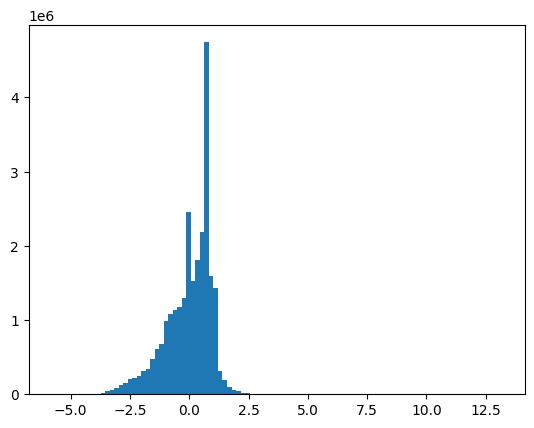

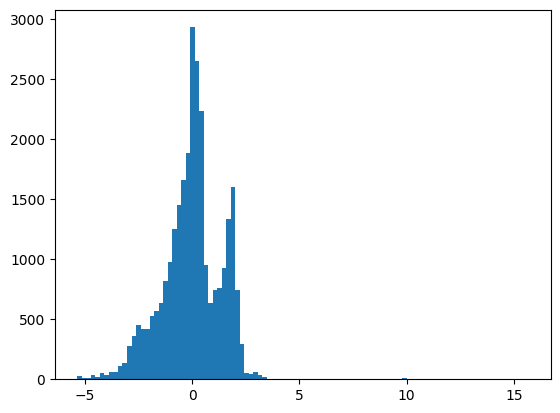

In [14]:
# np.sum(ppe_sim_train['vals'] > y_thresholds)
# test = np.log10(tgt_sim['vals'][0,7204:10804])
# test_finite = test[np.isfinite(test)]
a = 0
# ytrue = tgt_sim['vals'][:,a+6:a+3606]
# ytrue[~np.isfinite(ytrue)] = np.nan
# plt.hist(ytrue.flatten())
# plt.figure()
# plt.hist(y_all[:,5:65].flatten(), bins=100)
# plt.figure()
# plt.hist(tgt_all[:,5:65].flatten(), bins=100)

plt.hist(ppe_all[:,a+4:a+2580].flatten(), bins=100)
plt.figure()
plt.hist(tgt_all[:,a+4:a+2580].flatten(), bins=100)

In [15]:
tgt_all.shape

(11, 2884)

In [16]:
np.mean(tgt_all)

-0.091592919292204

## multi-output model

In [17]:
x_train.shape

(8000, 12)

In [18]:
proj_name = 'try14_rainshaft_Vmx_r1'
tuner = kt.RandomSearch(
    lambda hp: tu.build_classreg_model(hp, npar, nobs),
    objective="val_loss",
    max_trials=50,
    directory=lp.bossppe_dir+'/hp_tuning_withclass/multi-output',
    project_name=proj_name,
)


stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    x_train,
    {'presence': y_train_wpresence, 'water': y_train},
    epochs=50,
    validation_data=(x_val, {'presence': y_val_wpresence, 'water': y_val}),
    callbacks=([stop_early])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)



Trial 50 Complete [00h 00m 57s]
val_loss: 0.10873264074325562

Best val_loss So Far: 0.05590762943029404
Total elapsed time: 00h 41m 11s


In [19]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │      3,328 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 224)       │     57,568 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 96)        │     21,600 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      3,104 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 160)       │      5,280 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence (Dense)    │ (None, 2884)      │    464,324 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ water (Dense)       │ (None, 2884)      │    464,324 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,019,528 (3.89 MB)

 Trainable params: 1,019,528 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_presence_accuracy', mode='max', patience=1000)

train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, {'presence': y_train_wpresence, 'water': y_train}))
                 .shuffle(buffer_size=len(x_train))
                 .cache()
                 .batch(32)
                 .prefetch(tf.data.AUTOTUNE))

val_dataset = (tf.data.Dataset.from_tensor_slices((x_val, {'presence': y_val_wpresence, 'water': y_val}))
               .cache()
               .batch(32)
               .prefetch(tf.data.AUTOTUNE))

history = best_model.fit(
    train_dataset,
    epochs=10000,
    verbose=0,
    validation_data=val_dataset,
    callbacks=[TqdmCallback(verbose=1), stop_early]
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

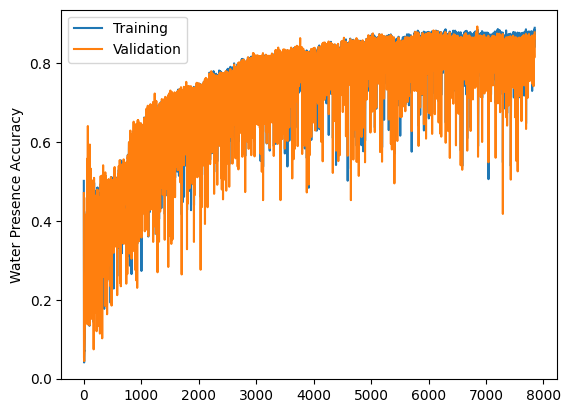

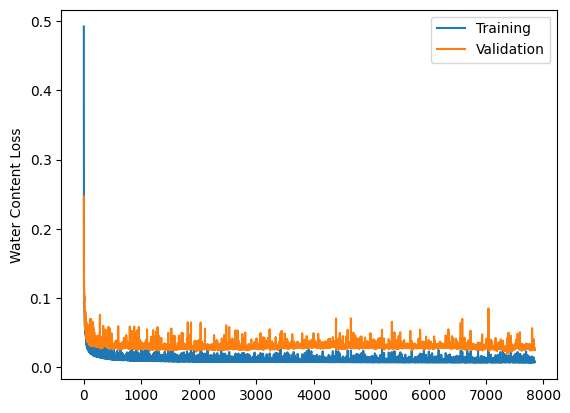

In [21]:
plt.figure()
plt.plot(history.epoch, history.history['presence_accuracy'], label='Training')
plt.plot(history.epoch, history.history['val_presence_accuracy'], label='Validation')
plt.ylabel('Water Presence Accuracy')
plt.legend()

plt.figure()
plt.plot(history.epoch, history.history['water_loss'], label='Training')
plt.plot(history.epoch, history.history['val_water_loss'], label='Validation')
plt.ylabel('Water Content Loss')
plt.legend()

In [22]:
# save model:
best_model.save(lp.bossppe_dir + '/models/multioutput_' + proj_name + '.keras')

## validation

In [66]:
best_model = tf.keras.models.load_model('models/multioutput_try10_rainshaft_narrow_VMx.keras', compile=False)

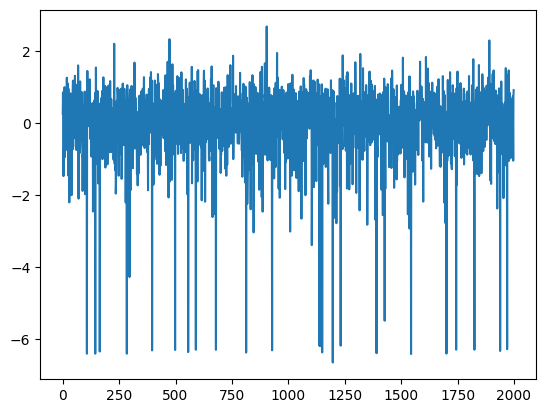

In [23]:
# best_model = tf.keras.models.load_model('models/multioutput_try28_condcoll_fullmom_nopartition_asinh.keras', compile=False)
plt.plot(best_model(x_val)[1][:, 0])
# cc_model(x_val)[1]

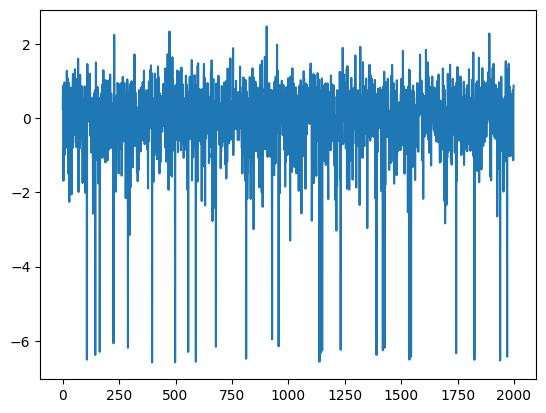

In [24]:
plt.plot(y_val[:,0])

In [25]:
best_model(x_val)[0]

<tf.Tensor: shape=(2000, 2884), dtype=float32, numpy=
array([[9.9999988e-01, 9.9999988e-01, 9.9999988e-01, ..., 8.5943711e-08,
        8.8062897e-08, 9.0050712e-08],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 2.6641822e-10,
        2.5927704e-10, 2.9853195e-10],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 8.2515250e-10,
        1.0756885e-09, 9.9623743e-10],
       ...,
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 4.2649098e-10,
        6.8795891e-10, 4.4056001e-10],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 6.5676602e-09,
        6.2892846e-09, 6.2187993e-09],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 7.2257866e-10,
        7.0743317e-10, 7.5809981e-10]], dtype=float32)>

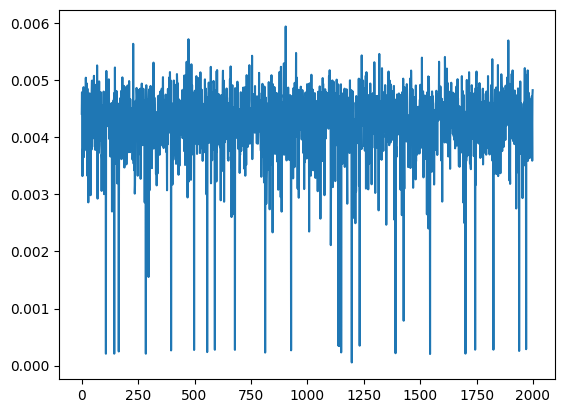

In [26]:
y_pred = standscale.inverse_transform(best_model(x_val)[1].numpy()) * best_model(x_val)[0]
# y_pred = model(x_val)
plt.plot(y_pred[:,0])

In [27]:
standscale.inverse_transform(y_train)

array([[0.00425761, 0.09942431, 0.2065321 , ..., 0.        , 0.        ,
        0.        ],
       [0.00439902, 0.10451503, 0.20687743, ..., 0.        , 0.        ,
        0.        ],
       [0.0043693 , 0.09933996, 0.21281424, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00377887, 0.08642947, 0.18198048, ..., 0.        , 0.        ,
        0.        ],
       [0.00391819, 0.09264139, 0.18922917, ..., 0.        , 0.        ,
        0.        ],
       [0.0043547 , 0.10356929, 0.21456654, ..., 0.        , 0.        ,
        0.        ]])

In [28]:
var_len = [int(np.prod(ppe_raw_vals[i].shape[1:])) for i in range(len(ppe_raw_vals))]
itr = list([np.arange(0, var_len[0])])
for ivlen, vlen in enumerate(var_len[1:]):
    itr.append(np.arange(itr[ivlen][-1]+1, itr[ivlen][-1]+1+vlen))

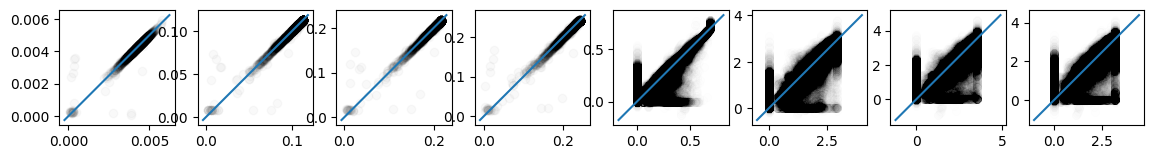

In [29]:
y_pred = standscale.inverse_transform(best_model(x_val)[1].numpy()) * best_model(x_val)[0].numpy()
# y_pred = standscale.inverse_transform(model(x_val).numpy())
# y_pred = np.exp(standscale.inverse_transform(model(x_val).numpy()))
y_val_lin = standscale.inverse_transform(y_val)
# y_train_lin = np.exp(standscale.inverse_transform(y_train))



fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(1,8)
ivar = 0
for i in range(len(eff0s)):
    ax = fig.add_subplot(gs[i])
    ax.set_aspect('equal')

    vlen = y_val_lin[:,itr[i]].size
    alpha = max(1/np.sqrt(vlen), 0.002)
    plt.scatter(y_val_lin[:,itr[i]].flatten(), y_pred[:,itr[i]].flatten(), alpha=alpha, c='k')
    # plt.scatter(ppe_sim_valid['vals'][:,i], y_pred[:,i],alpha=0.2,c='k')
    # plt.scatter(y_val[:,i], y_pred[:,i],alpha=0.2,c='k')
    # plt.title(ppe_sim_train['var_names'][i])
    ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
    ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
    plt.plot([ax_min, ax_max], [ax_min, ax_max])
    # ax.set_xscale('log')
    # ax.set_yscale('log')
# fig.tight_layout()
# plt.savefig(plot_dir + proj_name + '.png')

0.005

In [243]:
itr[i]

array([2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174,
       2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185,
       2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196,
       2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207,
       2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218,
       2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229,
       2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240,
       2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251,
       2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262,
       2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273,
       2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284,
       2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295,
       2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306,
       2307, 2308, 2309, 2310, 2311, 2312, 2313, 23